In [76]:
import symnum
import symnum.numpy as snp
import simsde
import numpy as np
import jax.numpy as jnp
from jax import jit, value_and_grad, lax, vmap
from jax.lax import scan
import matplotlib.pyplot as plt
from jax.config import config
import mici
import arviz
import corner
import csv 
import pandas as pd
import time
config.update('jax_enable_x64', True)
config.update('jax_platform_name', 'cpu')
from scipy.io import loadmat
from pathlib import Path

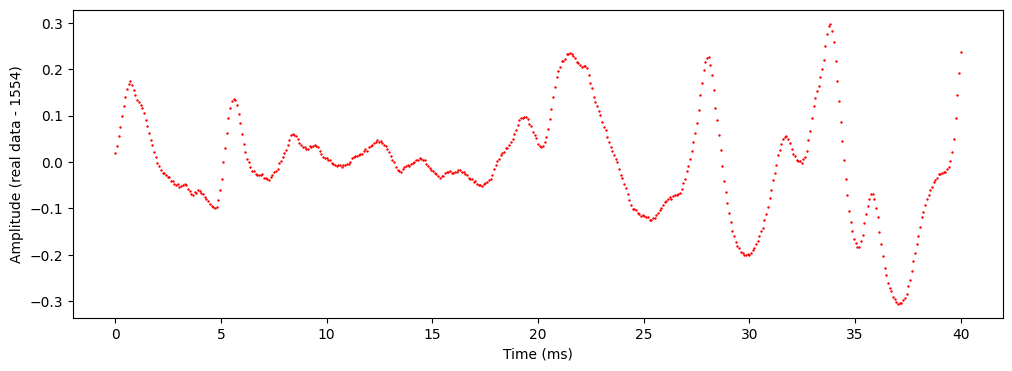

In [77]:
data_set = loadmat("1554.mat") 
raw_data = data_set['rawdata']

dt_original = 0.02
dt_data = 0.08
t_max = 40
t_seq_data = np.arange(int(t_max / dt_data) + 1) * dt_data
t_seq_original = np.arange(int(t_max / dt_original) + 1) * dt_original

num_obs = int(t_max / dt_original +1)
y_obs_original = raw_data[:num_obs,1]
y_obs_sparse = y_obs_original[::int(dt_data/dt_original)]

fig, ax = plt.subplots(figsize=(12, 4))
ax.plot(t_seq_data, y_obs_sparse, linestyle='None', color='r', marker='+', markersize=2)
ax.set_xlabel('Time (ms)')
ax.set_ylabel('Amplitude (real data - 1554)')
plt.show()



In [78]:
def drift_func_rough(x, θ):
    ε, γ, β, *_= θ
    return snp.array([
        γ*x[1] - x[0] + β
        ]) 

def drift_func_smooth(x, θ):
    ε, *_= θ
    return snp.array([
        (x[1] - x[1]**3 - x[0]) / ε
        ])

def diff_coeff_rough(x, θ):
    ε, γ, α, σ = θ
    return snp.array([[σ]])

def drift_func(x, θ):
    return snp.concatenate((drift_func_rough(x, θ), drift_func_smooth(x, θ)))

def diff_coeff(x, θ):
    return snp.concatenate((diff_coeff_rough(x, θ), snp.zeros((dim_x - dim_r, dim_w))), 0)

dim_x = 2
dim_r = 1
dim_w = 1
dim_θ = 4 

In [79]:
def generate_param(u):
    return jnp.array(
        [ 
            jnp.exp(u[0]), # ε
            jnp.exp(u[1]), # γ
            jnp.exp(u[2]), # β 
            jnp.exp(u[3]), # σ
        ]
    )

def generate_x_0(v_0):
    return jnp.array(
        [
            0.1*v_0[0], # q_0 
            0.2*v_0[1] # p_0 
        ]
    )

def generate_obs_noise(σ_0):
    return jnp.exp(0.5*σ_0 - 2)

In [80]:
def get_generate_x_seq_function(step_func):

    @jit
    def generate_x_seq(x_0, θ, n_seq, t_seq):
        
        def compute_next_state(x, n_dt):
            n, dt = n_dt
            x_next = step_func(x, θ, n, dt)
            return x_next, x_next
        
        _, x_seq = scan(compute_next_state, x_0, (n_seq, t_seq[1:] - t_seq[:-1]))
        
        return jnp.concatenate((x_0[None], x_seq))
        
    return generate_x_seq 

step_funcs_and_dim_n = {
    "local_gaussian": (
        simsde.integrators.hypoelliptic_local_gaussian_step(drift_func_rough, drift_func_smooth, diff_coeff_rough),
        2 * dim_w
    )
} 

generate_x_seq_functions = {
    key: get_generate_x_seq_function(
        symnum.numpify(dim_x, dim_θ, dim_n, (), numpy_module=jnp)(step_func)
    ) 
    for key, (step_func, dim_n) in step_funcs_and_dim_n.items()
}

In [81]:
dim_u = 4
dim_v_0 = 2
dim_σ_0 = 1

In [82]:
def get_posterior_density_functions(
    generate_param,
    generate_x_0,
    generate_x_seq, 
    t_seq, 
    dim_u, 
    dim_v_0, 
    obs_noise_std, 
    obs_time_indices,
    y_obs
    ):

    dim_z = dim_u + dim_v_0  

    @jit 
    def neg_log_posterior_density(q):
        u, v_0, n = q[:dim_u], q[dim_u:dim_z], q[dim_z:]
        n_seq = n.reshape((t_seq.shape[0] - 1, -1))
        θ = generate_param(u)
        x_0 = generate_x_0(v_0)
        x_seq = generate_x_seq(x_0, θ, n_seq, t_seq)
        # x_seq_at_obs = x_seq[obs_time_indices]
        smooth_state = (x_seq[obs_time_indices])[:,1]
    
        return (
            (((y_obs - smooth_state) / obs_noise_std)**2).sum()/2
            + (q**2).sum()/2
        ) 
    
    @jit 
    def grad_neg_log_posterior_density(q):
        val, grad = value_and_grad(neg_log_posterior_density)(q)
        return grad, val

    return {
        "neg_log_dens": lambda q: np.asarray(neg_log_posterior_density(q)), 
        "grad_neg_log_dens": lambda q: tuple(
            np.asarray(v) for v in grad_neg_log_posterior_density(q)
        )
    } 


In [83]:
plot_style = {
    'mathtext.fontset': 'cm',
    'font.family': 'serif',
    'axes.titlesize': 10,
    'axes.labelsize': 10,
    'xtick.labelsize': 6,
    'ytick.labelsize': 6,
    'legend.fontsize': 8,
    'legend.frameon': False,
    'axes.linewidth': 0.5,
    'lines.linewidth': 0.5,
    'axes.labelpad': 2.,
    'figure.dpi': 200,
}


In [84]:
n_chain = 2
obs_noise_std = 0.01
dt_obs = dt_data
n_warm_up_iter =4000
n_main_iter = 4000

traces = {}

common_kwargs = {
    "generate_param": generate_param,
    "generate_x_0": generate_x_0,
    "dim_u": dim_u,
    "dim_v_0": dim_v_0,
    "obs_noise_std": obs_noise_std, 
    "y_obs": y_obs_sparse
}

for method, dt, color in [
    ("local_gaussian", 0.0008, "C0"),
    ("local_gaussian", dt_data, "C1"),
]:
    print(f"method={method}, dt_sim={dt}")

    t_seq_inference = np.arange(int(t_max / dt) + 1) * dt
    generate_x_seq=generate_x_seq_functions[method]
    slice_indices = slice(0, None, int(dt_obs / dt))

    posterior_density_functions = get_posterior_density_functions(
        generate_x_seq = generate_x_seq,
        t_seq = t_seq_inference,  
        obs_time_indices = slice_indices, 
        **common_kwargs
    )

    def trace_func(state):
        θ = generate_param(state.pos[:dim_u])
        x_0 = generate_x_0(state.pos[dim_u:dim_u+dim_v_0])
        n_seq = state.pos[dim_v_0 + dim_u:].reshape((t_seq_inference.shape[0] - 1, -1))
        x_seq = generate_x_seq(x_0, θ, n_seq, t_seq_inference)
        return {"ε": θ[0], "α": θ[1], "β": θ[2], "σ": θ[3], "x_seq": x_seq} 

    dim_q = (
        common_kwargs["dim_u"] 
        + common_kwargs["dim_v_0"]
        + step_funcs_and_dim_n[method][1] * (len(t_seq_inference) - 1)
    )

    rng = np.random.default_rng(20241101)
    system = mici.systems.EuclideanMetricSystem(**posterior_density_functions)
    integrator = mici.integrators.LeapfrogIntegrator(system)
    sampler = mici.samplers.DynamicMultinomialHMC(system, integrator, rng)
    adapters = [mici.adapters.DualAveragingStepSizeAdapter(0.8)]
    init_states = []

    while len(init_states) < n_chain:
        q = rng.standard_normal(dim_q)
        g, v = system._grad_neg_log_dens(q)
        if not (np.any(np.isnan(g)) or np.isnan(v)):
            init_states.append(q)
    
    start = time.time()
    final_states, traces[method, dt], stats = sampler.sample_chains(
        n_warm_up_iter=n_warm_up_iter,
        n_main_iter=n_main_iter,
        init_states=init_states,
        monitor_stats=["n_step", "accept_stat"],
        trace_funcs=[trace_func],
        adapters=adapters,
        # n_process=1,
    )
    end = time.time()
    print(end-start)

    with open(f'FHN-mcmc-noise-NCP-{method}-T={t_max}-dt={dt}-warmup={n_warm_up_iter}-mainiter={n_main_iter}.csv', "w") as f:
        csv_w = csv.writer(f, lineterminator='\n')
        for index in ['ε', 'α', 'β', 'σ']:
            csv_w.writerows(traces[method, dt].get(index))
  
    x_seq = traces[method, dt].get('x_seq')
    for c in range(n_chain):
        with open(f'FHN-mcmc-smooth-T={t_max}-dt={dt}-warmup={n_warm_up_iter}-mainiter={n_main_iter}-chain{c+1}-noise={obs_noise_std}.csv', "w", newline="") as f:
            w = csv.writer(f, delimiter=",")
            for data_list in x_seq[c][:,:,1]:
                w.writerow(data_list)# print(p_seq) 

    for c in range(n_chain):
        with open(f'FHN-mcmc-rough-T={t_max}-dt={dt}-warmup={n_warm_up_iter}-mainiter={n_main_iter}-chain{c+1}-noise={obs_noise_std}.csv', "w", newline="") as f:
            w = csv.writer(f, delimiter=",")
            for data_list in x_seq[c][:,:,0]:
                w.writerow(data_list)# print(p_seq) 


method=local_gaussian, dt_sim=0.08


Sampling stage: Adaptive warm up [15:21] > Main non-adaptive [15:20]

Chain 1/2: 100%|██████████|4000/4000 [07:46<00:00, 8.57it/s, n_step=1.00e+03, accept_stat=0.796]

Chain 2/2: 100%|██████████|4000/4000 [07:33<00:00, 8.82it/s, n_step=975., accept_stat=0.781]

1841.3700230121613


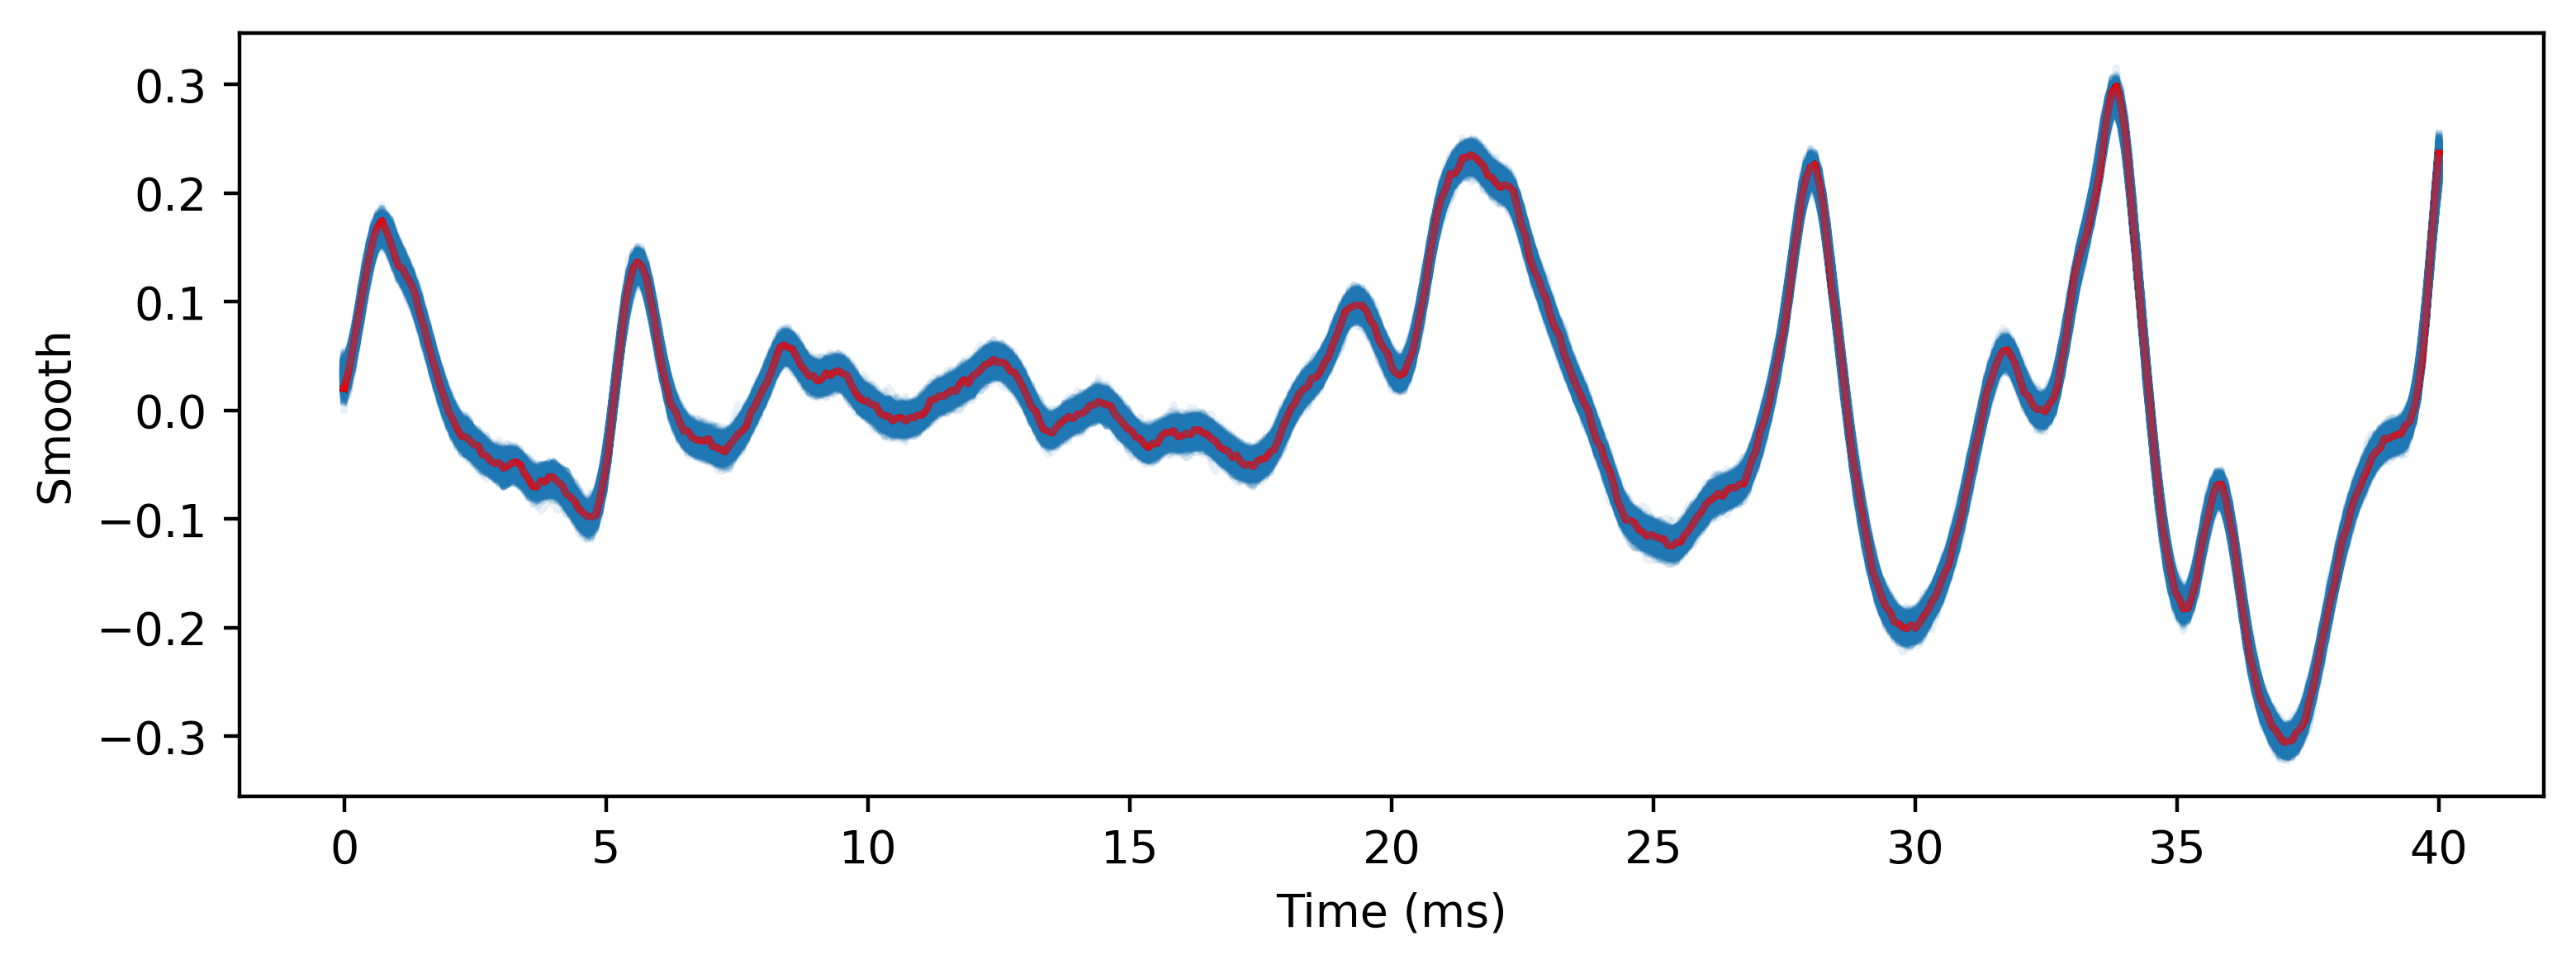

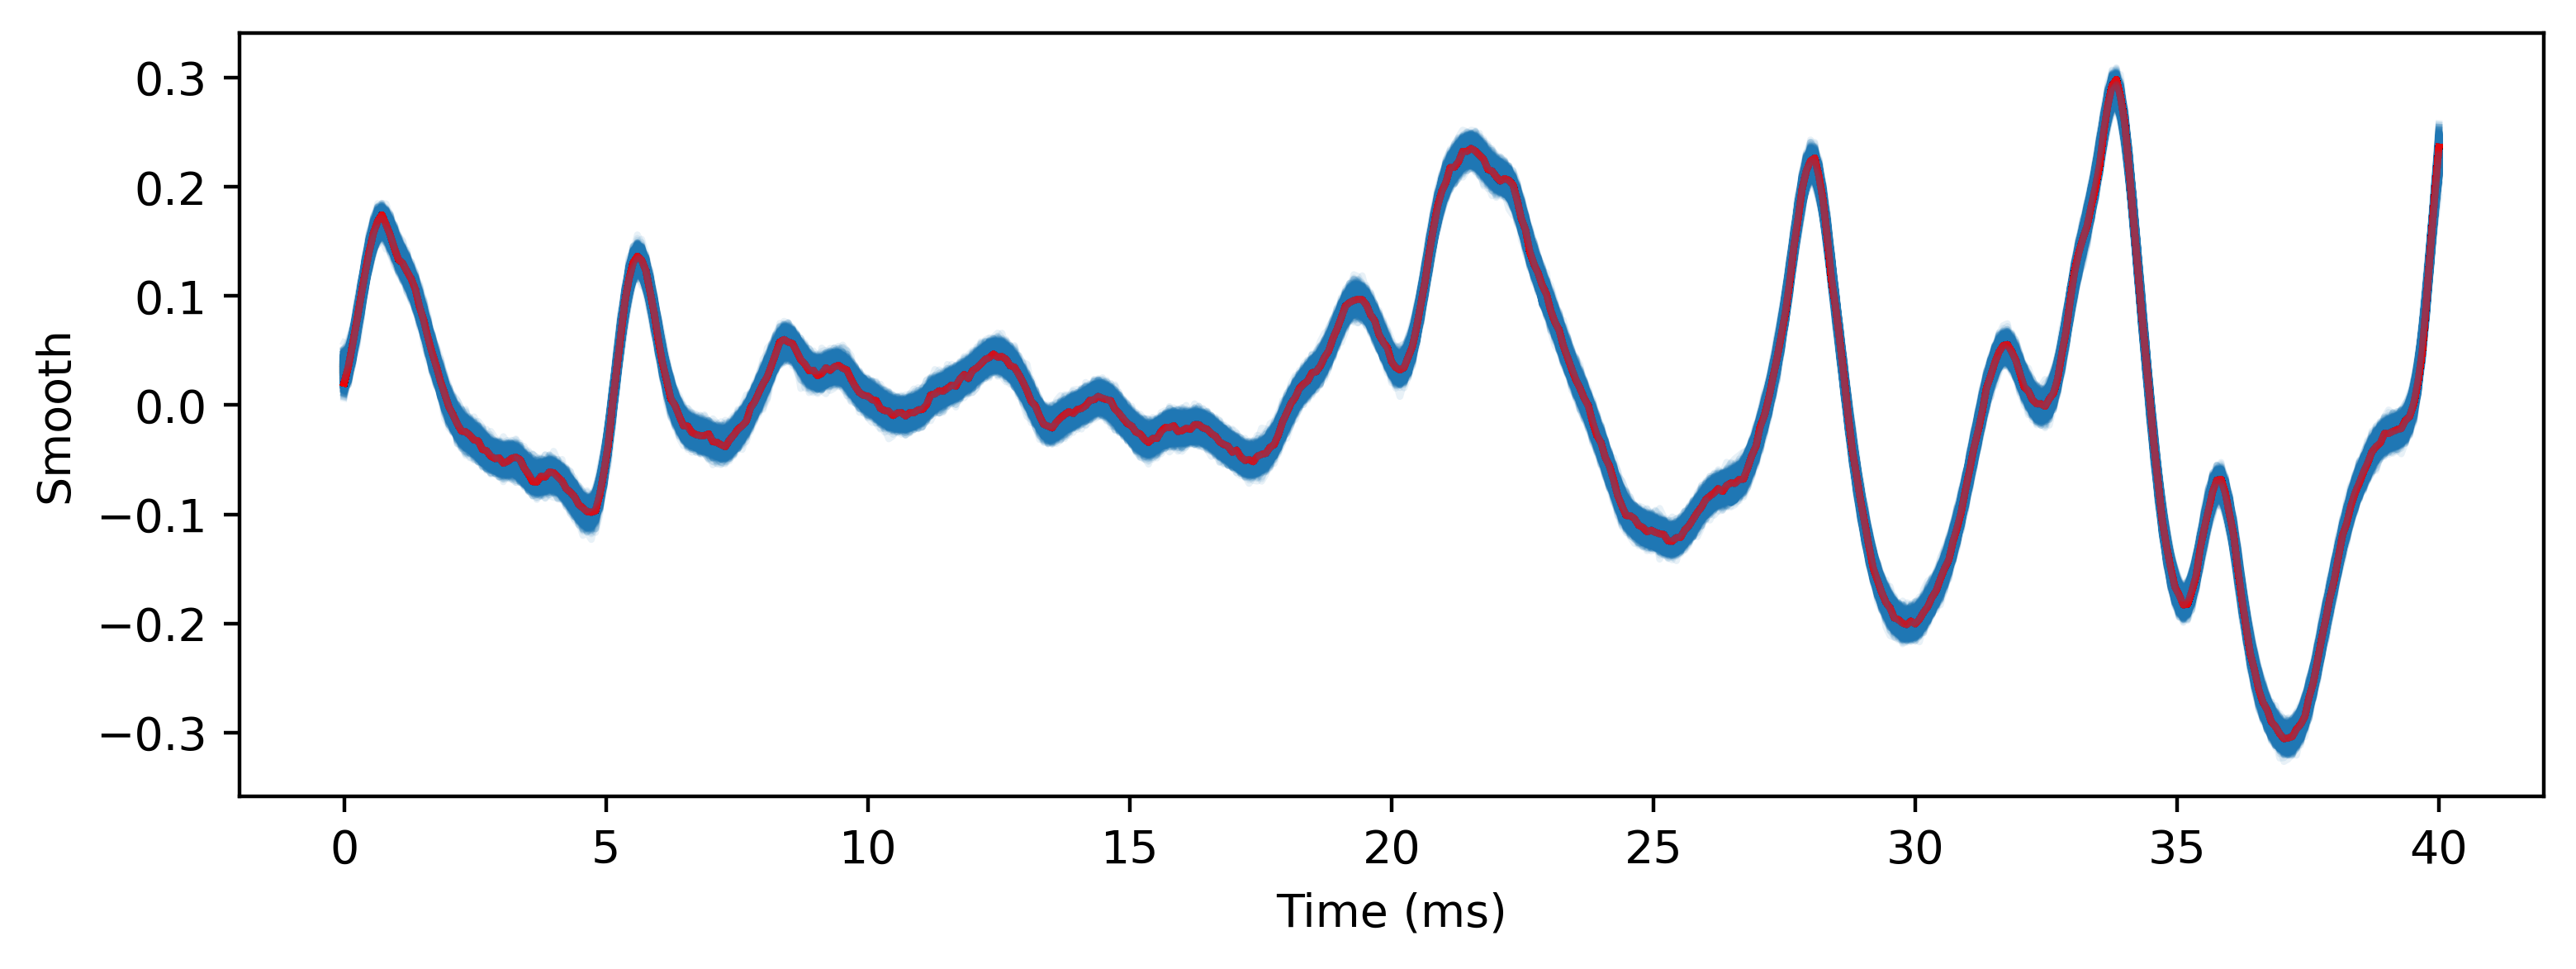

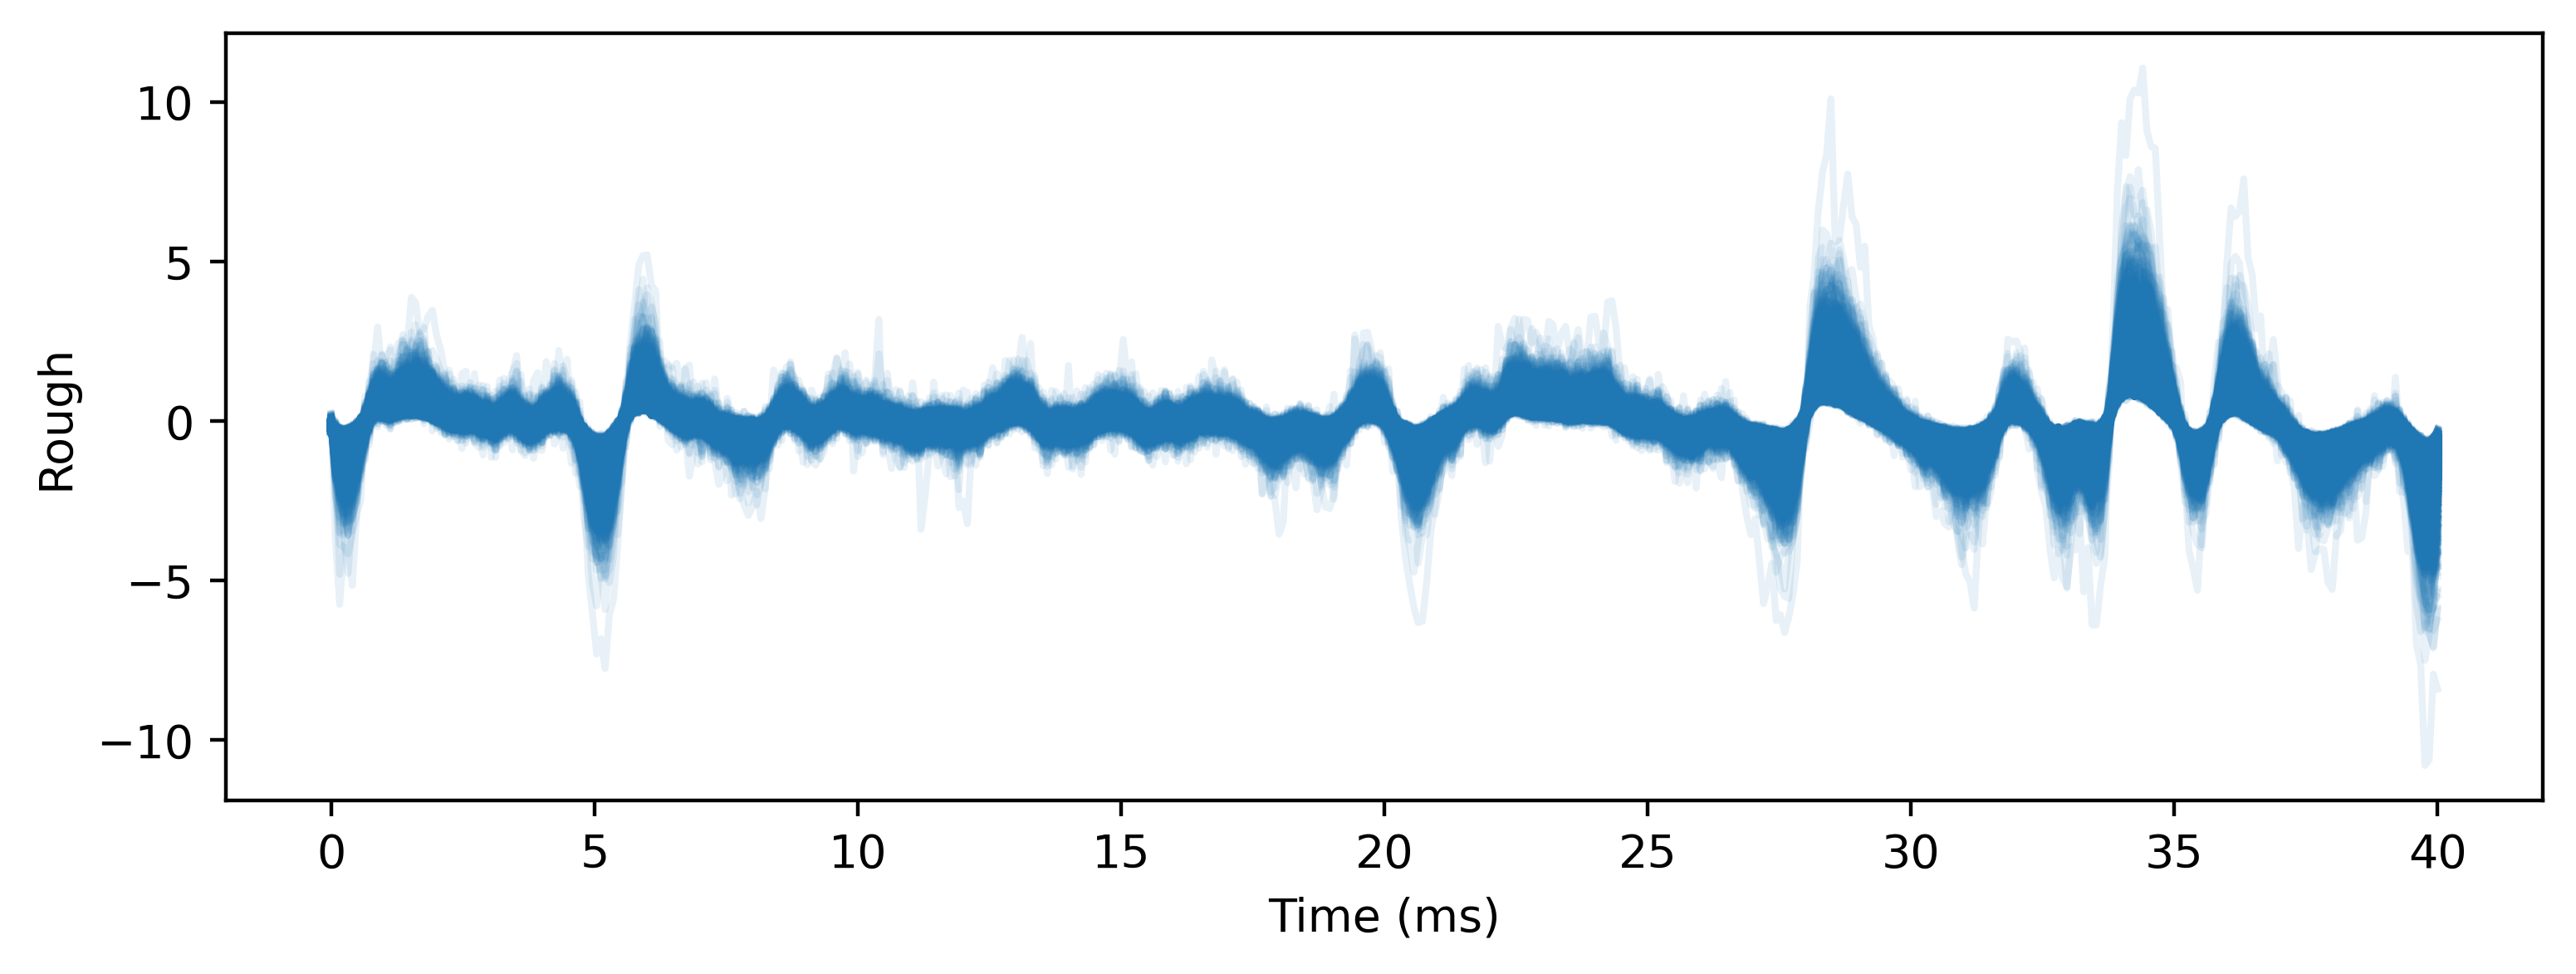

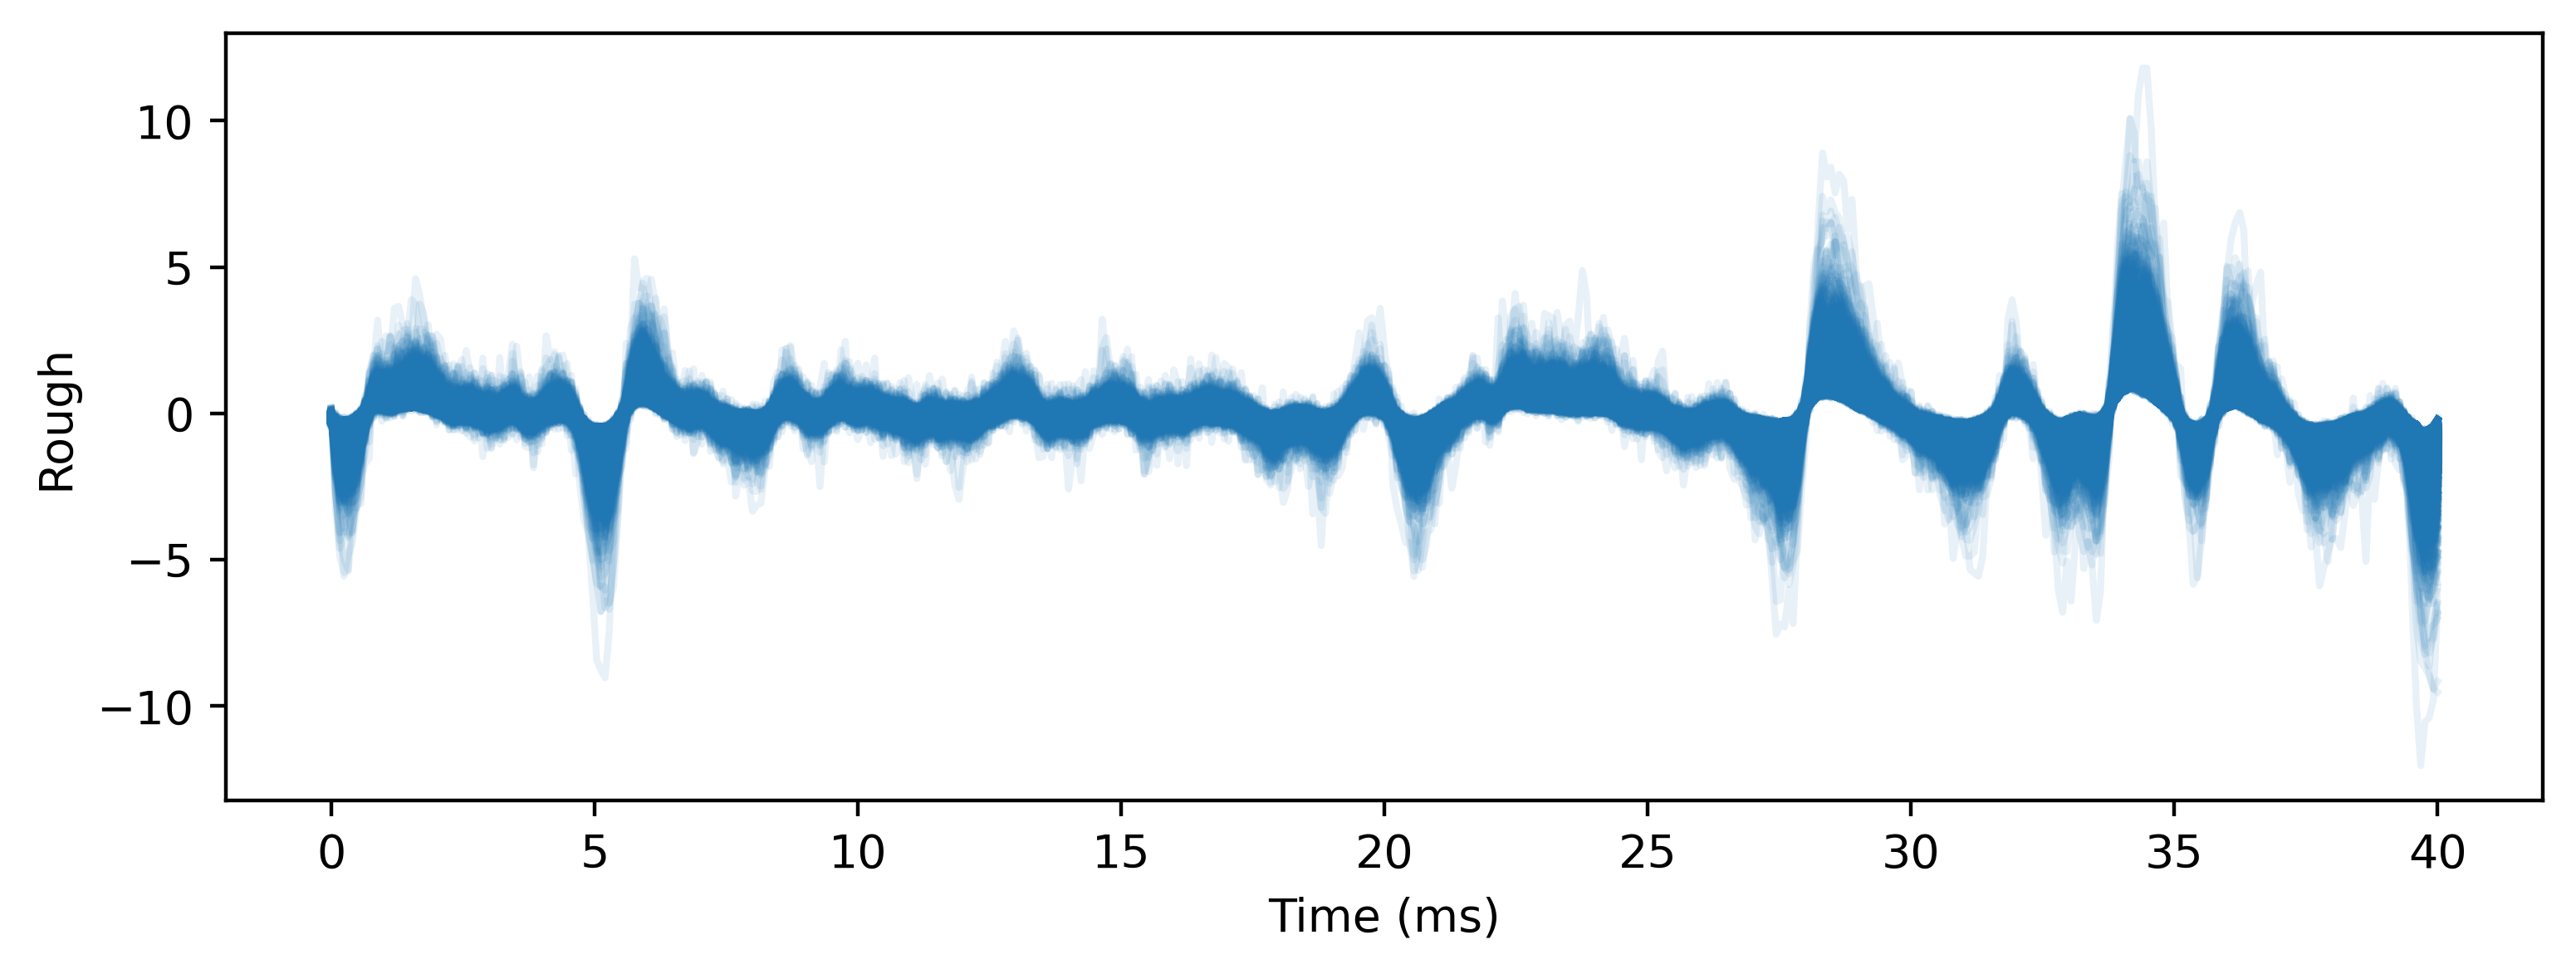

In [85]:
t_seq_obs = np.arange(int(t_max / dt_obs) + 1) * dt_obs

for method, dt in [
    ("local_gaussian", 0.0008),
    ("local_gaussian", dt_data),
]:
    t_seq_sim = np.arange(int(t_max / dt) + 1) * dt

    for c in range(n_chain):
        fig, ax = plt.subplots(sharex=True, figsize=(9, 3), dpi=400)
        for i in range(n_main_iter):
            q_seq = traces[method, dt].get('x_seq')[c][i,:,1]
            ax.plot(t_seq_sim, q_seq, color='C0', alpha=0.1)
            ax.plot(t_seq_obs, y_obs_sparse, 'r', alpha=0.1)
            ax.set_xlabel('Time (ms)')
            ax.set_ylabel('Smooth')
        
        fig.savefig(f"Smooth_T={t_max}-dt={dt}-warmup={n_warm_up_iter}-mainiter={n_main_iter}-chain{c+1}-noise={obs_noise_std}.png")
        plt.show()


    for c in range(n_chain):
        fig, ax = plt.subplots(sharex=True, figsize=(9, 3), dpi=400)
        for i in range(n_main_iter):
            p_seq = traces[method, dt].get('x_seq')[c][i,:,0]
            ax.plot(t_seq_sim, p_seq, color='C0', alpha=0.1)
            ax.set_xlabel('Time (ms)')
            ax.set_ylabel('Rough')
        
        fig.savefig(f"Rough_T={t_max}-dt={dt}-warmup={n_warm_up_iter}-mainiter={n_main_iter}-chain{c+1}-noise={obs_noise_std}.png")
        plt.show()
    
    
    x_seq = traces[method, dt].get('x_seq')

    for c in range(n_chain):
        with open(f'FHN-mcmc-smooth-T={t_max}-dt={dt}-warmup={n_warm_up_iter}-mainiter={n_main_iter}-chain{c+1}-noise={obs_noise_std}.csv', "w", newline="") as f:
            w = csv.writer(f, delimiter=",")
            for data_list in x_seq[c][:,:,1]:
                w.writerow(data_list)# print(p_seq) 

    for c in range(n_chain):
        with open(f'FHN-mcmc-rough-T={t_max}-dt={dt}-warmup={n_warm_up_iter}-mainiter={n_main_iter}-chain{c+1}-noise={obs_noise_std}.csv', "w", newline="") as f:
            w = csv.writer(f, delimiter=",")
            for data_list in x_seq[c][:,:,0]:
                w.writerow(data_list)# print(p_seq) 